In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.plotting import register_matplotlib_converters
from pandas.tseries.offsets import MonthEnd
from scipy.stats import iqr
import seaborn as sns

plt.style.use('fivethirtyeight')
register_matplotlib_converters()

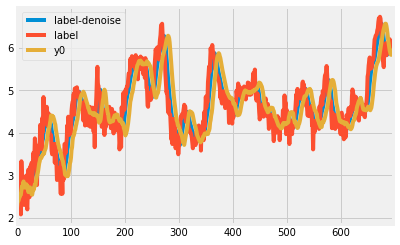

In [2]:
train_df = pd.read_csv("./input/train.csv")
train_df.head()
train_df[["label-denoise", "label", "y0"]].plot()

In [3]:
test_df = pd.read_csv("./input/test.csv")
test_df.head()

,label-denoise,label,y0,dengue-0,dengue-1,dengue-2,dengue-3,dengue-4,dengue-5,dengue-6,...,temp-12,temp-13,temp-14,temp-15,temp-16,temp-17,temp-18,temp-19,temp-20,temp-flag
0,6.016024,6.510258,5.463736,5.529429,5.645447,5.463832,5.505332,5.484797,5.420535,5.351858,...,1.062667,1.049333,1.036000,1.053778,1.054889,1.067556,1.070889,1.075778,1.082444,0
1,6.156472,6.793466,5.487790,5.568345,5.529429,5.645447,5.463832,5.505332,5.484797,5.420535,...,1.106222,1.062667,1.049333,1.036000,1.053778,1.054889,1.067556,1.070889,1.075778,0
2,6.283245,6.709304,5.516259,5.676754,5.568345,5.529429,5.645447,5.463832,5.505332,5.484797,...,1.107111,1.106222,1.062667,1.049333,1.036000,1.053778,1.054889,1.067556,1.070889,0
3,6.387613,6.616065,5.595103,6.061457,5.676754,5.568345,5.529429,5.645447,5.463832,5.505332,...,1.098316,1.107111,1.106222,1.062667,1.049333,1.036000,1.053778,1.054889,1.067556,0
4,6.431188,6.453625,5.673342,6.124683,6.061457,5.676754,5.568345,5.529429,5.645447,5.463832,...,1.108600,1.098316,1.107111,1.106222,1.062667,1.049333,1.036000,1.053778,1.054889,0


In [4]:
train_X = train_df.drop(columns=["label", "label-denoise", "y0"])
train_X.head()

,dengue-0,dengue-1,dengue-2,dengue-3,dengue-4,dengue-5,dengue-6,dengue-grad,temp-5,temp-6,...,temp-12,temp-13,temp-14,temp-15,temp-16,temp-17,temp-18,temp-19,temp-20,temp-flag
0,2.302585,2.079442,2.639057,2.079442,2.484907,2.564949,2.197225,1.572557,1.083,1.071,...,1.125,1.097,1.032,1.073,1.056,1.032,1.035,1.039,1.040,0
1,2.708050,2.302585,2.079442,2.639057,2.079442,2.484907,2.564949,-0.161254,1.089,1.083,...,1.061,1.125,1.097,1.032,1.073,1.056,1.032,1.035,1.039,0
2,2.397895,2.708050,2.302585,2.079442,2.639057,2.079442,2.484907,-1.770673,1.141,1.089,...,1.063,1.061,1.125,1.097,1.032,1.073,1.056,1.032,1.035,0
3,2.484907,2.397895,2.708050,2.302585,2.079442,2.639057,2.079442,-3.657450,1.151,1.141,...,1.051,1.063,1.061,1.125,1.097,1.032,1.073,1.056,1.032,0
4,3.091042,2.484907,2.397895,2.708050,2.302585,2.079442,2.639057,-3.576241,1.126,1.151,...,1.083,1.051,1.063,1.061,1.125,1.097,1.032,1.073,1.056,0


In [5]:
train_y = train_df[["label"]]
train_y.head()

,label
0,2.890372
1,3.218876
2,2.484907
3,3.135494
4,3.044522


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


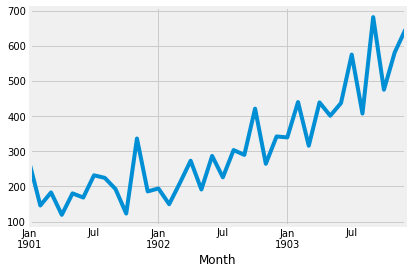

In [16]:
import math

# load and plot dataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# load dataset
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('./input/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())

# line plot
series.plot()
plt.show()

In [10]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(raw_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return train, test

In [11]:
# load dataset
series = pd.read_csv('./input/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# configure
n_lag = 1
n_seq = 3
n_test = 10
# prepare data
train, test = prepare_data(series, n_test, n_lag, n_seq)
print(test)
print('Train: %s, Test: %s' % (train.shape, test.shape))

[[342.3 339.7 440.4 315.9]
 [339.7 440.4 315.9 439.3]
 [440.4 315.9 439.3 401.3]
 [315.9 439.3 401.3 437.4]
 [439.3 401.3 437.4 575.5]
 [401.3 437.4 575.5 407.6]
 [437.4 575.5 407.6 682. ]
 [575.5 407.6 682.  475.3]
 [407.6 682.  475.3 581.3]
 [682.  475.3 581.3 646.9]]
Train: (23, 4), Test: (10, 4)


In [12]:
# make a persistence forecast
def persistence(last_ob, n_seq):
    return [last_ob for i in range(n_seq)]

# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = persistence(X[-1], n_seq)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [13]:
forecasts = make_forecasts(train, test, 1, 3)

In [24]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = test[:,(n_lag+i)]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = math.sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()

t+1 RMSE: 144.535304
t+2 RMSE: 86.479905
t+3 RMSE: 121.149168


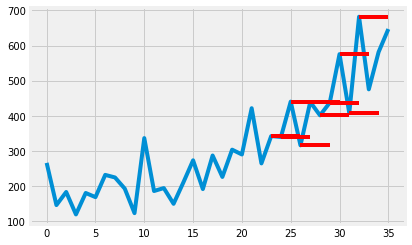

In [25]:
evaluate_forecasts(test, forecasts, 1, 3)
plot_forecasts(series, forecasts, n_test+2)

In [29]:
from math import sqrt

from matplotlib import pyplot
from numpy import array

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [31]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    pyplot.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

In [35]:
# load dataset
series = read_csv('./input/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64

In [37]:
# configure
n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 1500
n_batch = 1
n_neurons = 1
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
train

array([[-0.63999169,  0.01392642, -0.40594471,  0.11286635],
       [ 0.01392642, -0.40594471,  0.11286635, -0.18977344],
       [-0.40594471,  0.11286635, -0.18977344,  0.12242777],
       [ 0.11286635, -0.18977344,  0.12242777, -0.17106631],
       [-0.18977344,  0.12242777, -0.17106631, -0.27250052],
       [ 0.12242777, -0.17106631, -0.27250052, -0.43130326],
       [-0.17106631, -0.27250052, -0.43130326,  0.74724589],
       [-0.27250052, -0.43130326,  0.74724589, -0.76678445],
       [-0.43130326,  0.74724589, -0.76678445, -0.10579921],
       [ 0.74724589, -0.76678445, -0.10579921, -0.32695905],
       [-0.76678445, -0.10579921, -0.32695905,  0.11120349],
       [-0.10579921, -0.32695905,  0.11120349,  0.12201206],
       [-0.32695905,  0.11120349,  0.12201206, -0.48118894],
       [ 0.11120349,  0.12201206, -0.48118894,  0.25670339],
       [ 0.12201206, -0.48118894,  0.25670339, -0.39430472],
       [-0.48118894,  0.25670339, -0.39430472,  0.18187487],
       [ 0.25670339, -0.

In [ ]:
# # fit model
# model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# # make forecasts
# forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# # inverse transform forecasts and test
# forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
# actual = [row[n_lag:] for row in test]
# actual = inverse_transform(series, actual, scaler, n_test+2)
# # evaluate forecasts
# evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# # plot forecasts
# plot_forecasts(series, forecasts, n_test+2)